In [40]:
# DATASET  : https://www.cis.fordham.edu/wisdm/dataset.php
# WISDM_ar_v1.1_raw.txt

In [56]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.layers import Conv1D, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [48]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("D:/HAR/WISDM/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

(1098203, 6)


In [50]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,4
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,4
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,4
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,4


<Axes: xlabel='activity', ylabel='count'>

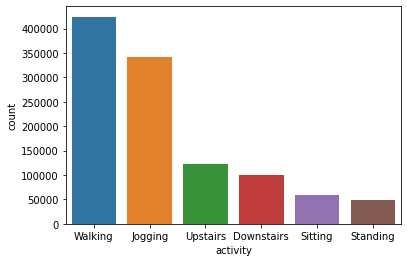

In [51]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

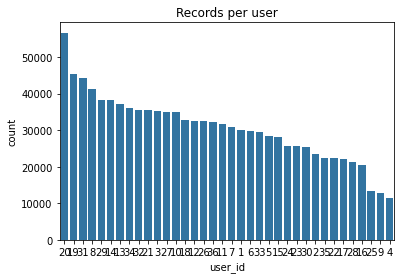

In [52]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");

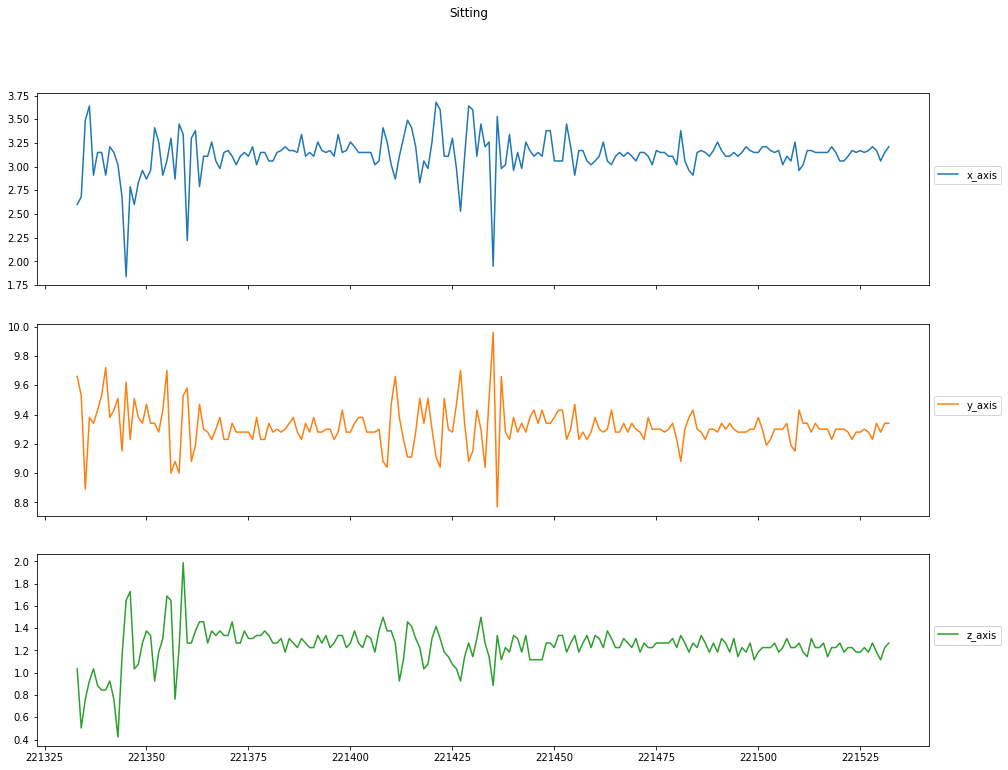

In [53]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)

In [54]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]
scaler = RobustScaler()
scaler = scaler.fit(df[scale_columns])
df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.131961,0.566215,0.102015,1
1,33,Jogging,49106062271000,0.648740,0.397381,0.193001,1
2,33,Jogging,49106112167000,0.633834,0.351926,-0.016543,1
3,33,Jogging,49106222305000,-0.120782,1.259408,0.612089,1
4,33,Jogging,49106332290000,-0.199038,0.498032,1.458535,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,1.194254,-1.132300,0.342105,4
1098200,19,Sitting,131623371431000,1.199726,-1.119190,0.350202,4
1098201,19,Sitting,131623411592000,1.205198,-1.109654,0.342105,4
1098202,19,Sitting,131623491487000,1.194254,-1.119190,0.350202,4


In [57]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17568, 200, 3) (17568, 1)
(5491, 200, 3) (5491, 1)


In [58]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(17568, 200, 3) (17568, 6) (5491, 200, 3) (5491, 6)


In [59]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 6)

# CNN Model

In [60]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 198, 64)           640       
                                                                 
 flatten_1 (Flatten)         (None, 12672)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1622144   
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1623558 (6.19 MB)
Trainable params: 1623558 (6.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 198, 64)           640       
                                                                 
 flatten_1 (Flatten)         (None, 12672)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1622144   
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1623558 (6.19 MB)
Trainable params: 1623558 (6.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
validation_split = 0.1
history = model.fit(X_train, y_train_hot, batch_size= 192, epochs=10, verbose=True,  validation_split=validation_split)

Epoch 1/10
83/83 [==============================] - 5s 57ms/step - loss: 0.9441 - accuracy: 0.6735 - val_loss: 0.5846 - val_accuracy: 0.8071
Epoch 2/10
83/83 [==============================] - 4s 52ms/step - loss: 0.4776 - accuracy: 0.8243 - val_loss: 0.4279 - val_accuracy: 0.8566
Epoch 3/10
83/83 [==============================] - 4s 51ms/step - loss: 0.3462 - accuracy: 0.8752 - val_loss: 0.3755 - val_accuracy: 0.8606
Epoch 4/10
83/83 [==============================] - 5s 55ms/step - loss: 0.2694 - accuracy: 0.9060 - val_loss: 0.3436 - val_accuracy: 0.8754
Epoch 5/10
83/83 [==============================] - 5s 61ms/step - loss: 0.2148 - accuracy: 0.9263 - val_loss: 0.3248 - val_accuracy: 0.8873
Epoch 6/10
83/83 [==============================] - 5s 59ms/step - loss: 0.1626 - accuracy: 0.9495 - val_loss: 0.2958 - val_accuracy: 0.8947
Epoch 7/10
83/83 [==============================] - 5s 56ms/step - loss: 0.1322 - accuracy: 0.9618 - val_loss: 0.2988 - val_accuracy: 0.9004
Epoch 8/10
83

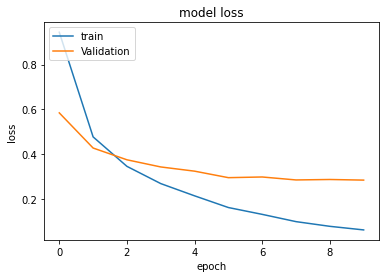

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

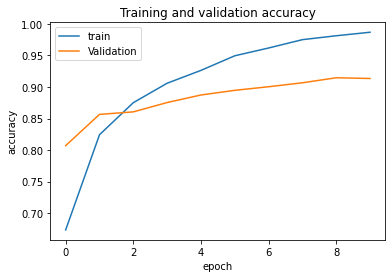

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 1s 4ms/step
f1_score =  0.9038810167001093
0.9080313239847022
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2123
           1       0.94      0.98      0.96      1710
           2       0.78      0.66      0.72       614
           3       0.76      0.62      0.68       502
           4       1.00      0.97      0.99       300
           5       0.96      0.97      0.97       242

    accuracy                           0.91      5491
   macro avg       0.89      0.86      0.88      5491
weighted avg       0.90      0.91      0.90      5491



<Axes: >

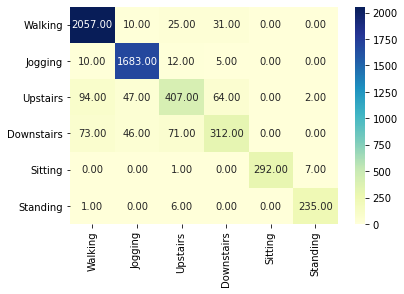

In [66]:


y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')